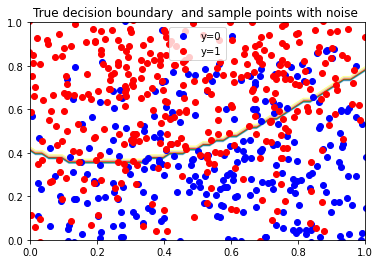

No handles with labels found to put in legend.


0.847
0.871


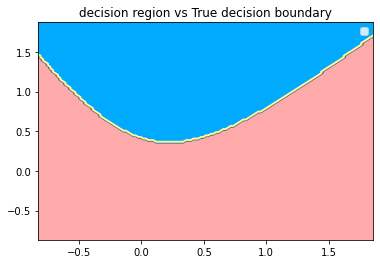

No handles with labels found to put in legend.


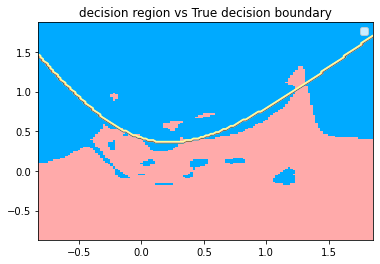

No handles with labels found to put in legend.


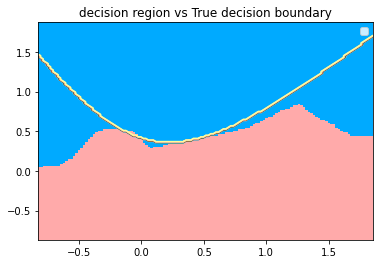

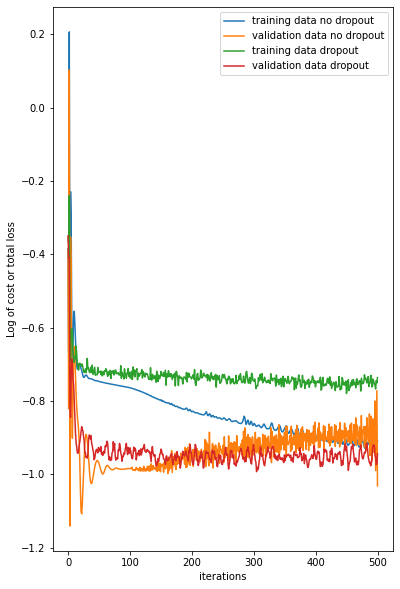

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap


def plot_decision_regions_3class(data_set,model=None):

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min()-0.1 , X[:, 0].max()+0.1 
    y_min, y_max = X[:, 1].min()-0.1 , X[:, 1].max() +0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    newdata=np.c_[xx.ravel(), yy.ravel()]
    
    #XX=torch.torch.Tensor(newdata)
    #_,yhat=torch.max(model(XX),1)
    #yhat=yhat.numpy().reshape(xx.shape)
    
    Z=data_set.fun(newdata).flatten()
    f=np.zeros(Z.shape)
    f[Z>0]=1
    f=f.reshape(xx.shape)
    if model!=None:
        model.eval()
        XX=torch.torch.Tensor(newdata)
        _,yhat=torch.max(model(XX),1)
        yhat=yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")
    plt.legend()
    plt.show()
 
def accuracy(model,data_set):
  _,yhat=torch.max(model(data_set.x),1)
  return (yhat==data_set.y).numpy().mean()


from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self,N_SAMPLES = 1000,noise_std=0.1,train=True):
      
        a=np.matrix([-1,1,2,1,1,-3,1]).T
        
        self.x = np.matrix(np.random.rand(N_SAMPLES,2))

        self.f=np.array(a[0]+(self.x)*a[1:3]+np.multiply(self.x[:,0], self.x[:,1])*a[4]+np.multiply(self.x, self.x)*a[5:7]).flatten()
        self.a=a
       
        self.y=np.zeros(N_SAMPLES)
        self.y[self.f> 0]=1
        self.y=torch.from_numpy(self.y).type(torch.LongTensor)
        self.x=torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x+noise_std*torch.randn(self.x.size())
        self.f=torch.from_numpy(self.f)
        self.a=a
        if train==True:
            torch.manual_seed(1)
         
            self.x = self.x+noise_std*torch.randn(self.x.size())
            torch.manual_seed(0)
        
            
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len
    def plot(self):
        X=data_set.x.numpy()
        y=data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min() , X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        Z=data_set.fun(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f=np.zeros(Z.shape)
        f[Z>0]=1
        f=f.reshape(xx.shape)
        plt.title('True decision boundary  and sample points with noise ')
      

        plt.plot(self.x[self.y==0,0].numpy(),self.x[self.y==0,1].numpy(),'bo',label='y=0' ) 
        plt.plot(self.x[self.y==1,0].numpy(), self.x[self.y==1,1].numpy(),'ro',label='y=1' )
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
        plt.show()


    def fun(self,x):
        
        x=np.matrix(x)

        out=np.array(self.a[0]+(x)*self.a[1:3]+np.multiply(x[:,0], x[:,1])*self.a[4]+np.multiply(x, x)*self.a[5:7])
        out=np.array(out)
        return out
  
data_set=Data(noise_std=0.2)
data_set.plot()

torch.manual_seed(0) 
validation_set=Data(train=False)


model = nn.Sequential(
    nn.Linear(2,300),
    nn.ReLU(),
    nn.Linear(300,300),
    nn.ReLU(),
    nn.Linear(300,2)
)

model_d = nn.Sequential(
    nn.Linear(2,300),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(300,300),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(300,2)
)

model_d.train()

optimiser = torch.optim.Adam(model.parameters(),lr=0.01)
optimiser_D = torch.optim.Adam(model_d.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs=500

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

def train(epochs):
  for epoch in range(epochs):
    yhat = model(data_set.x)
    yhat_d = model_d(data_set.x)
    loss = criterion(yhat,data_set.y)
    loss_d = criterion(yhat_d,data_set.y)

    LOSS['training data no dropout'].append(loss.item())
    LOSS['training data dropout'].append(loss_d.item())
    model.eval()
    LOSS['validation data no dropout'].append(criterion(model(validation_set.x),validation_set.y).item())
    LOSS['validation data dropout'].append(criterion(model_d(validation_set.x),validation_set.y).item())
    model.train()

    optimiser.zero_grad()
    optimiser_D.zero_grad()
    loss.backward()
    loss_d.backward()
    optimiser.step()
    optimiser_D.step()

train(500)

model.eval()

z = model(validation_set.x)
_,yhat = z.max(1)
print((yhat==validation_set.y).numpy().mean())

z = model_d(validation_set.x)
_,yhat_d = z.max(1)
print((yhat_d==validation_set.y).numpy().mean())

plot_decision_regions_3class(data_set)
plot_decision_regions_3class(data_set,model)
plot_decision_regions_3class(data_set,model_d)
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)),label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")